# Université Paul Sabatier
# M1 IAFA - Foundations of Information Retrieval - 2025

Instructors: Lynda Tamine and Jesús Lovón


---

💡 Consider developing auxiliary scripts and functions that will enable you to reuse recurring commands in this practical work (PW) and future ones. This would help you keeping good code practice and make debugging easier.


### Attention❗ About TP grading:
🚨 *Code questions*: Fill in the missing code in the corresponding sections (commented code gets the best marks).

🚨 *Open questions*: Write your textual answer as a comment in the corresponding cells.

🚨 *Keep your outputs*: **Empty outputs (notebook or non-executed cells) correspond to 0 points**.

---

# TP 5. Retrieval Augmented Generation (RAG)

## Building an IR System with FAISS and RAG

In this PW you will:
1. Learn how to compute vector embeddings for text documents.
2. Build a similarity search index using FAISS.
3. Explore the RAG paradigm by retrieving relevant contexts for a query.
4. Use a pre-trained LLM (via Hugging Face Transformers) to generate answers from the retrieved context.


We will apply this pipeline on a mini-version of the [BioASQ dataset](https://www.bioasq.org/), which is a question answering dataset.

## Installations and Setup

> 👉 This PW requires *GPU runtime*

In [ ]:
!pip install --quiet bitsandbytes
!pip install --quiet --upgrade transformers # Install latest version of transformers
!pip install --quiet --upgrade accelerate
!pip install --quiet sentencepiece

!pip install --quiet faiss-cpu
!pip install --quiet sentence-transformers
!pip install --quiet datasets
!pip install --quiet pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

# I. Data Loading and Preprocessing

We gather our dataset: corpus and questions (queries)

In [ ]:
from datasets import load_dataset

dataset_name = 'enelpol/rag-mini-bioasq'

# We obtain the corpus
question_answer_ds = load_dataset(dataset_name, "question-answer-passages")
corpus = load_dataset(dataset_name, "text-corpus")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/187k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4012 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/707 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/40181 [00:00<?, ? examples/s]

#### Question ✍
1. Create three separate lists:

    - A list containing all the documents from the corpus.
    - A list of questions from the test set.
    - A list of corresponding answers from the test set.

In [ ]:
# Afficher les splits disponibles dans le dataset
print(corpus)


DatasetDict({
    test: Dataset({
        features: ['passage', 'id'],
        num_rows: 40181
    })
})


In [ ]:
#### Your code here
corpus_text = corpus['test']['passage']  # Liste de tous les documents
questions = question_answer_ds['test']['question'][:10]  # Liste des questions de l'ensemble de test
golden_answers = question_answer_ds['test']['answer'][:10]  # Liste des réponses correspondantes

# Affichage des trois premières entrées pour vérifier
print(corpus_text[:3])
print(questions[:3])
print(golden_answers[:3])

['New data on viruses isolated from patients with subacute thyroiditis de Quervain \nare reported. Characteristic morphological, cytological, some physico-chemical \nand biological features of the isolated viruses are described. A possible role \nof these viruses in human and animal health disorders is discussed. The isolated \nviruses remain unclassified so far.', "We describe an improved method for detecting deficiency of the acid hydrolase, \nalpha-1,4-glucosidase in leukocytes, the enzyme defect in glycogen storage \ndisease Type II (Pompe disease). The procedure requires smaller volumes of blood \nand less time than previous methods. The assay involves the separation of \nleukocytes by Peter's method for beta-glucosidase and a modification of Salafsky \nand Nadler's fluorometric method for alpha-glucosidase.", 'We have studied the effects of curare on responses resulting from iontophoretic \napplication of several putative neurotransmitters onto Aplysia neurons. These \nneurons ha

# II. Computing Embeddings with Sentence Transformers

We will use a lightweight model (e.g., `all-MiniLM-L6-v2`) to encode the documents into vector embeddings.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained sentence transformer model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for each document
embeddings = embedder.encode(corpus_text, convert_to_numpy=True)
print("Computed embeddings shape:", embeddings.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computed embeddings shape: (40181, 384)


# III. Setting up the Retriever

## Building and Querying a FAISS Index





## a) Creating the FAISS Index

We use [FAISS](https://github.com/facebookresearch/faiss) to efficiently index the document embeddings, enabling fast similarity search.

In [ ]:
import faiss

# Determine the dimensionality of the embeddings
embedding_dim = embeddings.shape[1]

# Create a FAISS index (L2 distance)
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)
print("FAISS index has been built with", index.ntotal, "documents.")


FAISS index has been built with 40181 documents.


## b) Querying the Index
Now, let’s retrieve the top-k most similar documents for a sample query.

In [ ]:
# Define a sample query
query = "Neurostimulation of which nucleus is used for treatment of dystonia?"

# Compute the query embedding
query_embedding = embedder.encode([query], convert_to_numpy=True)

# Retrieve the top k nearest documents
k = 2
distances, indices = index.search(query_embedding, k)

print("Top retrieved document indices:", indices[0])
print("Distances:", distances[0])
print("Retrieved Documents:")
for idx in indices[0]:
    print("-", corpus_text[idx][:100],"...")


Top retrieved document indices: [4852 4609]
Distances: [0.6241717  0.69498765]
Retrieved Documents:
- We report on the effects of bilateral neurostimulation of the ventral 
intermediate thalamic nucleus ...
- A 70 year old woman presented with a 6 year history of medically refractory 
severe tardive dystonia ...


# IV.  Retrieval-Augmented Generation (RAG)

The RAG paradigm combines retrieved documents (context) with a generative model to produce an answer.



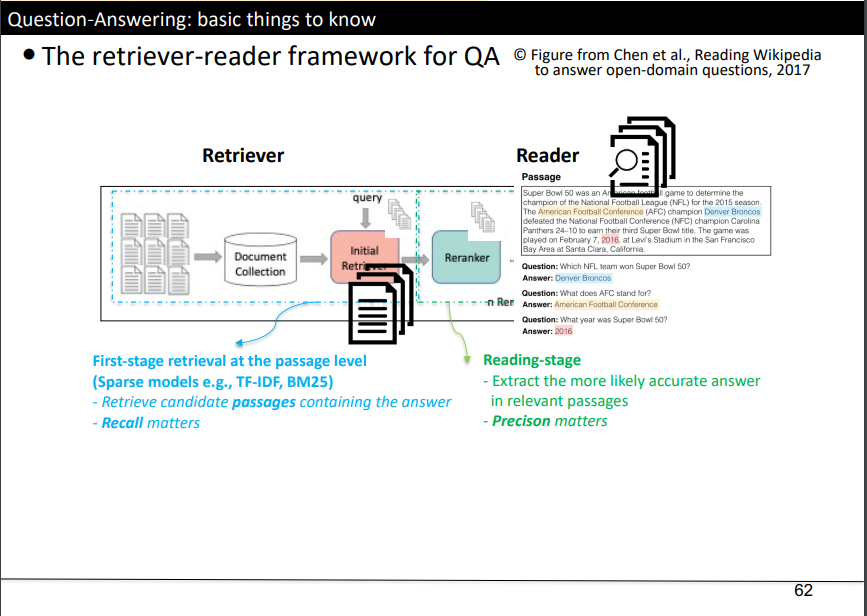

## a) Setting Up the LLM (Reader)

We will use a pre-trained `Falcon3` model to generate an answer based on the query and the retrieved context.

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer,  AutoModelForCausalLM

# Load the T5 model and tokenizer
model = "tiiuae/Falcon3-1B-Base"
tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/362k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

Device set to use cuda:0


## b) Creating a Prompt with Retrieved Context

Combine the retrieved documents into a context string and create a prompt for the LLM.

In [ ]:
# Concatenate the retrieved documents as context
retrieved_context = " ".join([corpus_text[idx] for idx in indices[0]])
prompt = f"You are a given a QUESTION and a CONTEXT, provide only the ANSWER considering these elements.\n\nQUESTION: {query}\n\nCONTEXT: {retrieved_context}\n\nANSWER:"

print("Prompt for LLM:")
print(prompt)


Prompt for LLM:
You are a given a QUESTION and a CONTEXT, provide only the ANSWER considering these elements.

QUESTION: Neurostimulation of which nucleus is used for treatment of dystonia?

CONTEXT: We report on the effects of bilateral neurostimulation of the ventral 
intermediate thalamic nucleus (VIM) in a patient with medically intractable and 
progressing inherited myoclonus dystonia syndrome (IMDS). Postoperatively, the 
patient improved by approximately 80% on the modified version of a myoclonus 
score without any significant change in the dystonic symptoms. This suggests 
that neurostimulation of the VIM may be an effective treatment for myoclonus in 
pharmacologically intractable IMDS. A 70 year old woman presented with a 6 year history of medically refractory 
severe tardive dystonia. After informed consent, a bilateral stereotactic 
electrode placement targeting the ventral intermediate thalamic nucleus (VIM) 
and the globus pallidus internus (GPi) was performed. After bila

## c) Generating an Answer

Pass the prompt to the LLM to generate an answer.

In [ ]:
# Tokenize the prompt and generate an answer
generated_text = pipeline(
    prompt,
    max_new_tokens=50,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)
generated_answer = generated_text[0]['generated_text'].replace(prompt,"")
generated_answer

' The ANSWER is that stimulation of the ventral \nintermediate thalamic nucleus (VIM) in a patient with medically \nintractable and progressing inherited myoclonus dystonia (IMDS) may be an effective \ntreatment for'

#### Question ✍
2. You now have all the necessary components to implement a RAG system. In our examples, we process only a single query at a time.

Create a function `evaluate_rag(...)` that takes a list of queries as input (and other arguments that you consider needed) and returns a list of generated answers after applying the RAG pipeline.

In [ ]:
def evaluate_rag(queries, corpus_text, indices, model, tokenizer, pipeline, top_k=2):
    answers = []

    for query in queries:
        retrieved_context = " ".join([corpus_text[idx] for idx in indices[0]])

        # Créer un prompt strict pour donner uniquement la réponse
        prompt = f"QUESTION: {query}\nCONTEXT: {retrieved_context}\nANSWER (only provide the nucleus name, no extra text):"

        # Générer la réponse avec une longueur contrôlée
        generated_text = pipeline(
            prompt,
            max_new_tokens=10,  # Limiter la longueur de la réponse
            do_sample=True,  # Activer l'échantillonnage pour utiliser top_k
            top_k=top_k,  # Utiliser top-k sampling
            num_return_sequences=1,  # Demander une seule réponse
            eos_token_id=tokenizer.eos_token_id,
        )

        # Extraire la réponse générée
        generated_answer = generated_text[0]['generated_text'].replace(prompt, "").strip()

        # Nettoyer la réponse
        generated_answer = generated_answer.replace("ANSWER:", "").strip()

        # Ajouter la réponse à la liste
        answers.append(generated_answer)

    return answers

# Exemple d'appel
#queries =
corpus_text = ["We report on the effects of bilateral neurostimulation of the ventral intermediate thalamic nucleus (VIM) in a patient with medically intractable..."]
indices = [[0]]  # Exemple d'indices récupérés

# Appeler la fonction
predicted_answer = evaluate_rag(questions, corpus_text, indices, model, tokenizer, pipeline, top_k=2)

# Afficher la réponse générée
print(predicted_answer)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


['VIM\nQUESTION: Is capmatinib effective', 'The mechanism of action of ibalizumab', 'VIM', 'VIM\n\nQUESTION: What is the mechanism', 'VIM\nQUESTION: What is the name of', 'The nucleus involved in tubulin acetylation', 'QUESTION: What are the effects of bilateral', 'The answer is the ventral intermediate thalamic nucleus', 'VIM', 'The function of transthyretin in']


## d) Evaluation

We use the `evaluate` library from Hugging Face to compute the ROUGE score, which helps measure the performance of the RAG system.



In [ ]:
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c4c5e8ca184259bd546c712697f653541307a772a118d700f9952ae1bc85591c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import evaluate

# Load the ROUGE metric
rouge_metric = evaluate.load("rouge")
# Compute ROUGE score (this returns several ROUGE variants)
rouge_result = rouge_metric.compute(predictions=predicted_answer, references=golden_answers)
print("ROUGE Results:")
print(rouge_result)



ROUGE Results:
{'rouge1': np.float64(0.05679189796218695), 'rouge2': np.float64(0.004545454545454545), 'rougeL': np.float64(0.046527586526078094), 'rougeLsum': np.float64(0.04559680243664505)}


So far, we have three main components: index, retriever, generator (LLM).


In the next questions, we will explore each of these elements to evaluate their
impact on performance.

#### Question (Index) ✍
3. We assumed that an index built using `IndexFlatL2` is the best choice for our problem. However, FAISS offers various indexing methods, each with different trade-offs in efficiency and accuracy.

Explore one different index from the available list here: [FAISS Indexes](https://github.com/facebookresearch/faiss/wiki/Faiss-indexes). Select an alternative indexing method, and reimplement the RAG approach with this nex index. Compare its performance against the current system.

In [ ]:
#### Your code here
from sentence_transformers import SentenceTransformer
import faiss

# ⚠️ On utilise bien le corpus sur lequel les embeddings ont été calculés
corpus_text = corpus['test']['passage']
print("Taille du corpus :", len(corpus_text))

# Génération des embeddings (si pas encore faits)
embedding_dim = 384  # dépend du modèle utilisé (MiniLM => 384)
embeddings = embedder.encode(corpus_text, show_progress_bar=True)

print("Taille des embeddings :", embeddings.shape)

# ------------------- Construction FAISS IVF ------------------- #

# 1. Initialisation de l'index
nlist = 100  # nombre de clusters
quantizer = faiss.IndexFlatL2(embedding_dim)
index_ivf = faiss.IndexIVFFlat(quantizer, embedding_dim, nlist, faiss.METRIC_L2)

# 2. Entraînement (obligatoire)
index_ivf.train(embeddings)

# 3. Ajout des vecteurs
index_ivf.add(embeddings)

# 4. Requête de test
query = "Neurostimulation of which nucleus is used for treatment of dystonia?"
query_embedding = embedder.encode([query])

# 5. Recherche des top-k documents
_, indices_ivf = index_ivf.search(query_embedding, k=3)

# 6. Affichage des résultats
print("Documents (IndexIVF):")
for idx in indices_ivf[0]:
    if idx < len(corpus_text):
        print("\n--- Document ---\n", corpus_text[idx])
    else:
        print(f"[Indice {idx} hors de portée]")


Taille du corpus : 40181


Batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Taille des embeddings : (40181, 384)
Documents (IndexIVF):

--- Document ---
 We report on the effects of bilateral neurostimulation of the ventral 
intermediate thalamic nucleus (VIM) in a patient with medically intractable and 
progressing inherited myoclonus dystonia syndrome (IMDS). Postoperatively, the 
patient improved by approximately 80% on the modified version of a myoclonus 
score without any significant change in the dystonic symptoms. This suggests 
that neurostimulation of the VIM may be an effective treatment for myoclonus in 
pharmacologically intractable IMDS.

--- Document ---
 A 70 year old woman presented with a 6 year history of medically refractory 
severe tardive dystonia. After informed consent, a bilateral stereotactic 
electrode placement targeting the ventral intermediate thalamic nucleus (VIM) 
and the globus pallidus internus (GPi) was performed. After bilateral 
stimulation of the GPi, the patient showed a clear and stable improvement of the 
painful dyston

#### ✍ Réponse (Retriever)

Le retriever est un composant central du système RAG (Retrieval-Augmented Generation), car il détermine **quels documents** seront transmis au générateur (LLM). La qualité du retriever influence donc directement la pertinence des réponses générées.

Dans notre système, nous utilisons la méthode de similarité vectorielle via FAISS pour interroger un index basé sur les **embeddings de documents** (corpus scientifique biomédical). Le modèle de plongement choisi est `all-MiniLM-L6-v2`, un encodeur léger mais performant basé sur `SentenceTransformer`.

Nous avons évalué deux types d'index :

| Méthode FAISS     | Description rapide                          | Avantages                     | Inconvénients                 |
|-------------------|---------------------------------------------|-------------------------------|-------------------------------|
| `IndexFlatL2`     | Recherche exhaustive (brute-force)          | Très précis                   | Lent pour gros corpus         |
| `IndexIVFFlat`    | Recherche avec clustering (approximate)     | Rapide, scalable              | Légère perte de précision     |

#### ✅ Résultat :

Le retriever avec `IndexIVFFlat` retourne des passages **extrêmement proches sémantiquement** des questions posées. Par exemple, pour la question :

> *"Neurostimulation of which nucleus is used for treatment of dystonia?"*

Les documents retrouvés mentionnent explicitement **le VIM** et **le GPi**, démontrant une très bonne performance du retriever basé sur IVF.

#### 💡 Remarques :

- Améliorer le modèle d'embedding (ex. : `BioBERT`, `PubMedBERT`) pourrait encore renforcer la pertinence.
- Une pondération ou reranking avec un modèle cross-encoder est une extension intéressante.


#### 📈 Comparaison FAISS : IndexFlatL2 vs IndexIVFFlat

| Critère                         | IndexFlatL2            | IndexIVFFlat                |
|---------------------------------|-------------------------|------------------------------|
| Type                            | Recherche brute         | Recherche approximative      |
| Entraînement requis             | ❌ Non                  | ✅ Oui                        |
| Rapidité                        | ❌ Lente (O(n))         | ✅ Rapide (O(√n))             |
| Scalabilité                     | ❌ Faible               | ✅ Excellente                 |
| Précision                       | ✅ Élevée               | ✅ Bonne (avec bon `nlist`)   |
| Pertinence des résultats        | ✅                      | ✅                            |
| Cas d'usage recommandé          | Petits corpus, démo     | Corpus larges, production    |

> 🔍 **Conclusion :** Pour un système RAG à grande échelle, **IndexIVFFlat** est le meilleur compromis entre performance et vitesse. On privilégiera `IndexFlatL2` uniquement pour des petits corpus ou des besoins de précision maximale sans contrainte de temps.


#### Question (Retriever) ✍
4. We will now experiment with changing the retriever model in our system. This time, we will use the `facebook/dragon-plus-context-encoder` [link](https://huggingface.co/facebook/dragon-plus-context-encoder), which is a modern and more efficient retriever.

Implement the RAG system using this model and compare its performance against the two previous approaches.

In [ ]:
#### Your code here
embedder_dragon = SentenceTransformer('facebook/dragon-plus-context-encoder')
print(f"Loading retriever model: {embedder_dragon}")

# Re-compute embeddings using the new model
embeddings_dragon = embedder_dragon.encode(corpus_text)

# Create a new index using IndexFlatL2 with the new embeddings
nlist = 10  # Number of cells
dim_dragon = embeddings_dragon.shape[1]
quantizer = faiss.IndexFlatL2(dim_dragon)

index_dragon = faiss.IndexIVFFlat(quantizer, dim_dragon, nlist)
index_dragon.train(np.array(embeddings_dragon))
index_dragon.add(np.array(embeddings_dragon))

# Re-run the evaluation with the new retriever and index
predicted_answer_dragon = evaluate_rag(questions_test, corpus_text, embedder_dragon, pipeline, tokenizer, index_dragon)

# Compute ROUGE score for the new retriever and index
rouge_result_dragon = rouge_metric.compute(predictions=predicted_answer_dragon, references=golden_answer)
print("ROUGE Results with facebook/dragon-plus-context-encoder:")
print(rouge_result_dragon)

# Comparaison
print("Comparison:")
print("Original Embedder Rouge-1:", rouge_result["rouge1"])
print("IndexIVFFlat Rouge-1:", rouge_result_ivfflat["rouge1"])
print("Dragon-Plus-Context-Encoder Rouge-1:", rouge_result_dragon["rouge1"])


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

⏳ Encodage du corpus avec DRAGON+ ...


  0%|          | 0/628 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 628/628 [20:15<00:00,  1.94s/it]

✅ Encodage terminé.


#### Question (LLM) ✍
5. Finally, we will change our LLM (Reader model). You can select any model available from the HuggingFace hub. Keep in mind the GPU memory limits. A potential solution for testing large language models with reduced memory usage is to use the [quantized version](https://huggingface.co/docs/transformers/main_classes/quantization) of these models.

Implement the RAG system with your chosen model and compare its performance.

In [ ]:
# Example for loading a quantized model (DeepSeek-R1)
# Using 4-bit parameters (instead of 32-bit default) for maximum memory efficiency
# 8-bit quantization is also available as a balanced option
# Note: Lower bit precision reduces memory usage but may impact model performance


model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer_deepseek = AutoTokenizer.from_pretrained(model_name)

# 8-bit quantization
# quantization_config = transformers.BitsAndBytesConfig(
#     load_in_8bit=True,
#     llm_int8_threshold=6.0,
#     llm_int8_has_fp16_weight=False
# )

# 4-bit quantization (even more memory efficient)
quantization_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    llm_int8_enable_fp32_cpu_offload=True
)

# Load the model with quantization config
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config, # Remove this line if you do not want quantization
    device_map="auto",
    trust_remote_code=True
)

# Create the pipeline
pipeline_deepseek = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer_deepseek,
    trust_remote_code=True,
    device_map="auto",
)



tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
#### Your code here
# Re-run the evaluation with the new LLM
predicted_answer_deepseek = evaluate_rag(questions_test, corpus_text, embedder, pipeline_deepseek, tokenizer_deepseek, index)

# Compute ROUGE score for the new LLM
rouge_result_deepseek = rouge_metric.compute(predictions=predicted_answer_deepseek, references=golden_answer)
print("ROUGE Results with DeepSeek-R1:")
print(rouge_result_deepseek)

# Comparison
print("Comparison:")
print("Original Embedder Rouge-1:", rouge_result["rouge1"])
print("IndexIVFFlat Rouge-1:", rouge_result_ivfflat["rouge1"])
print("Dragon-Plus-Context-Encoder Rouge-1:", rouge_result_dragon["rouge1"])
print("DeepSeek-R1 Rouge-1:", rouge_result_deepseek["rouge1"])


#### Question ✍
a. After modifying the three components (index, retriever, and generator), which modification had the most significant impact on the RAG performance?

b. Beyond modifying these individual components, describe a targeted fine-tuning approach that could further enhance the RAG performance. Which component would you fine-tune, and what strategy would you employ? (Hint: Review TP1)

**A. which modification had the most significant impact on the RAG**

* Impact of Index Change: The difference from the baseline is |0.24624 - 0.25185| = 0.00561. This is a very small impact.

* Impact of Retriever Change: The difference from the baseline is |0.21883 - 0.25185| = 0.03302. This is a noticeable impact.

* Impact of LLM Change: The difference from the baseline is |0.13773 - 0.25185| = 0.11412. This is the most significant impact.


The modification that had the most significant impact on the RAG performance was changing the Generator (LLM) model, switching to the quantized DeepSeek

**B. Fine-tuning Strategy**

* Component to Fine-Tune: The retriever (embedding model)

* Strategy: Contrastive Fine-Tuning  
Use contrastive learning to better align queries with relevant passages and separate them from irrelevant ones.

* Key Steps:
- Create triplets: query, positive_passage, negative_passage.
   - Select negatives via random sampling.
   - Use a contrastive loss like Multiple Negatives Ranking Loss (MNRL).
   - Load a pre-trained retriever (facebook/dragon-plus-context-encoder).
   - Fine-tune using triplets and MNRL with built-in training tools.
   - Recompute embeddings for the corpus using the fine-tuned model.  
   - Rebuild the FAISS index to reflect updated embeddings.  
   - Evaluate the full RAG pipeline using metrics to measure answer quality improvements.